In [6]:
import shap
import pickle
import numpy as np
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations
shap.initjs()
%matplotlib inline
task_name = '08'

In [7]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

In [8]:
try:
    with open(task_name + '.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = \
            pickle.load(f)
    print('loaded saved SHAP values')
except FileNotFoundError:
    pass

loaded saved SHAP values


# Generate SHAP Values

Now let's generate SHAP values for all instances for all of the available explanation types in all value spaces. We leave all settings to default, where a random sample of X is used as the background dataset that is used to mask out hidden features.

In [3]:
%%time
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X)
with open(task_name + '.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite),
                f, pickle.HIGHEST_PROTOCOL)

CPU times: user 12.6 s, sys: 180 ms, total: 12.7 s
Wall time: 13.7 s


The generated SHAP values are structured as follows:

In [12]:
list(explanations.__dict__.keys())

['indiv', 'bin_diff', 'mclass_diff', 'indiv_diff']

Individual models' SHAP values, binary difference classifier SHAP values, multiclass difference SHAP values and differences (subtraction) of individual models' SHAP values.

In [16]:
list(explanations.indiv.__dict__.keys())

['labels', 'proba', 'log_odds']

Each of them has SHAP values for predicted labels, probabilities and log odds. We will choose the most appropriate space during analysis.

All SHAP values have a basic shape of (300 instances, 2 features):

In [17]:
explanations.indiv.labels.A.shape

(300, 2, 2)

And in the third dimension the predicted classes (0, 1 in case of this binary classifier)

In [18]:
explanations.indiv_diff.labels.shape

(300, 2, 2)

In [19]:
explanations.bin_diff.labels.shape

(300, 2)

These are the SHAP values for the class 'predictions are different'

In [20]:
explanations.mclass_diff.labels.shape

(300, 2, 4)

And the SHAP values for the multiclass difference classification task have 4 classes in the third dimension

In [24]:
explanations.mclass_diff.labels.output_names

['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']

No instances were filtered during the process:

In [21]:
indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((0,), (0,))

# Global Explanations

## Feature importance

First, we investigate the feature importance for each model's positive class individually.

We measure the feature importance in terms of the mean absolute SHAP value per feature. Why take the absolute of the SHAP values? Because it allows us to take into account both positive and negative influences in a single ranking measure.

### Individual Explanations

Here we calculate the feature importance based on probability SHAP values. For both classifiers, x2 is of much higher importance for the predictions than x1. The ratio between the features seems to be very similar for both classifiers.

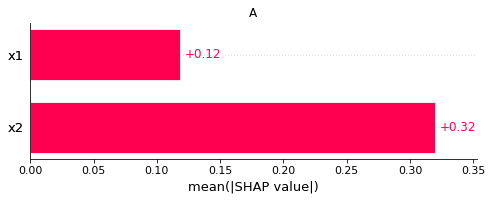

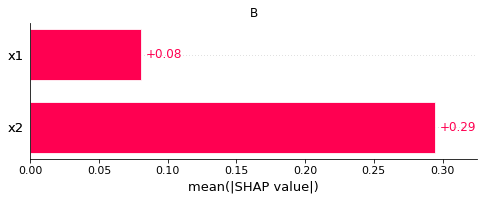

In [10]:
plot_feature_importance_bar(explanations.indiv.proba.A[:, :, 1], title='A')
plot_feature_importance_bar(explanations.indiv.proba.B[:, :, 1], title='B')

The scatter plots of the SHAP values per feature per model reveal the same information unaggregated. We can see, that for both models similarly, instances with low to medium values of x1, x1 has a slight positive influence, while for high values of x1, x1 has a quite big negative influence on the outcome. For x2 it's more extreme and with even more having a negative impact on the prediction.

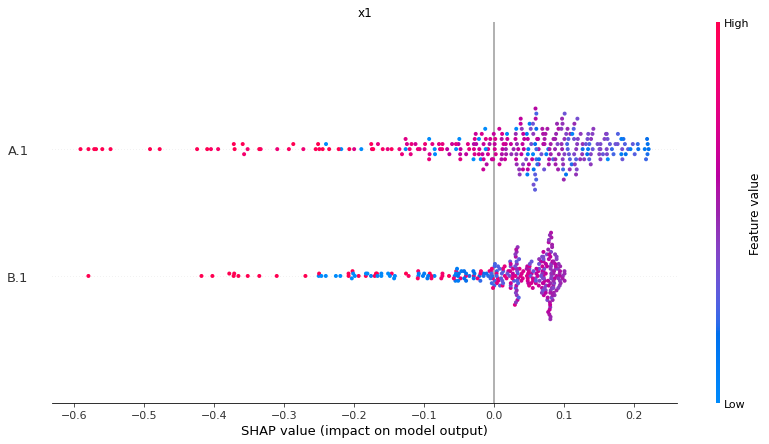

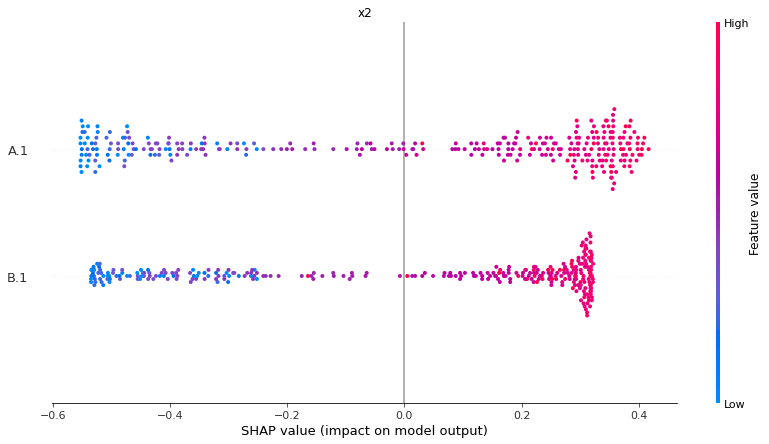

In [6]:
plot_feature_importance_scatter(explanations.indiv.proba[:, :, 1])

SHAP values for label predictions can be disregarded in this case, because they do not simplify the information.

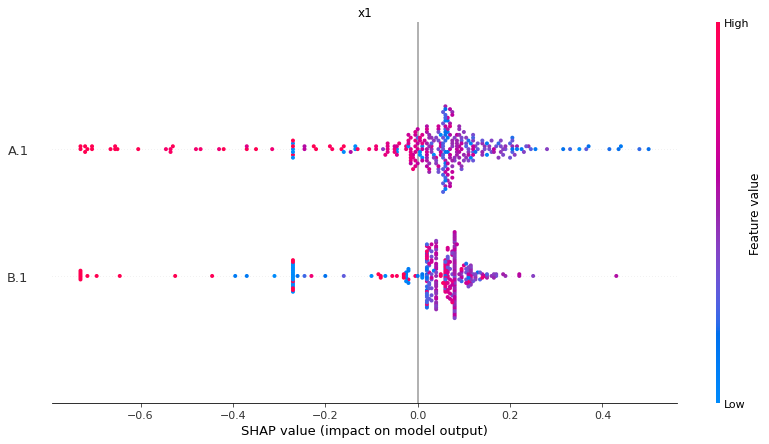

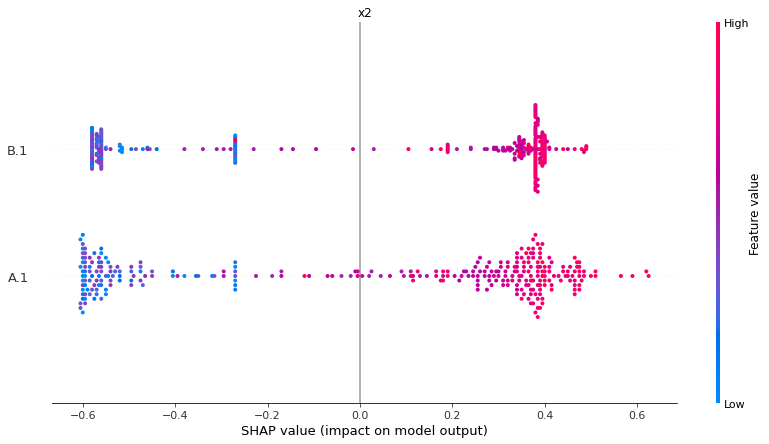

In [9]:
plot_feature_importance_scatter(explanations.indiv.labels[:, :, 1])

Whereas log odds SHAP values offer a closer view into how the two models work under the hood: SHAP values for B concentrate heavily on specific values of influence on the positive side, with a long tail to the negative most probably for the instances that are classified as the negative class. Note, that on the log odds scale 0 represents 50% and the farther it is away from that value, the more "evidence" for or against a prediction. -35 log odds equals a probability of approx. $6 \cdot 10^{-16}$. So the model is quite sure about these predictions.

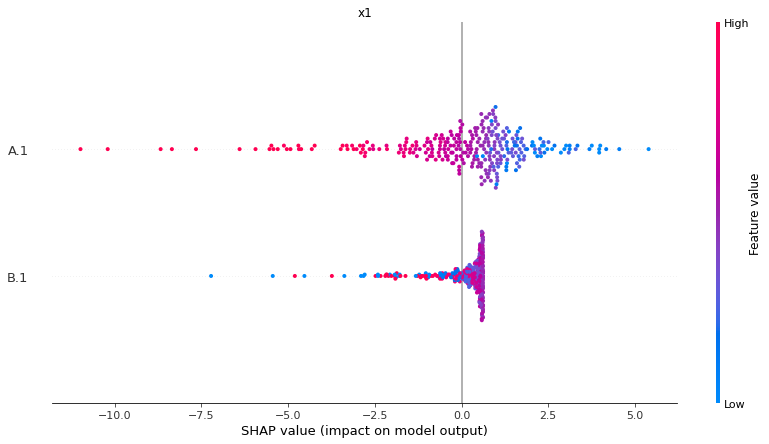

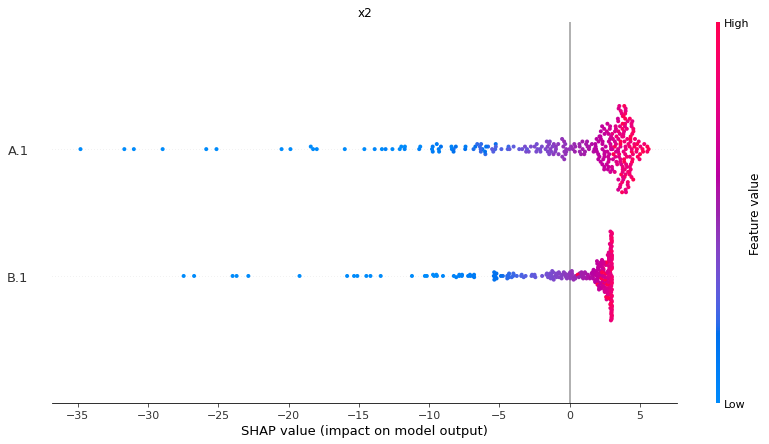

In [8]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, :, 1])

SHAP values offer the ability to actually subtract them, because of their additivity. This is one way to analyze the differences. It's best to do that with the SHAP values generated for log-odds predictions, because this space has additive properties as well.

For x1, low feature values have higher SHAP values for A than for B, while for x2 it is the opposite.

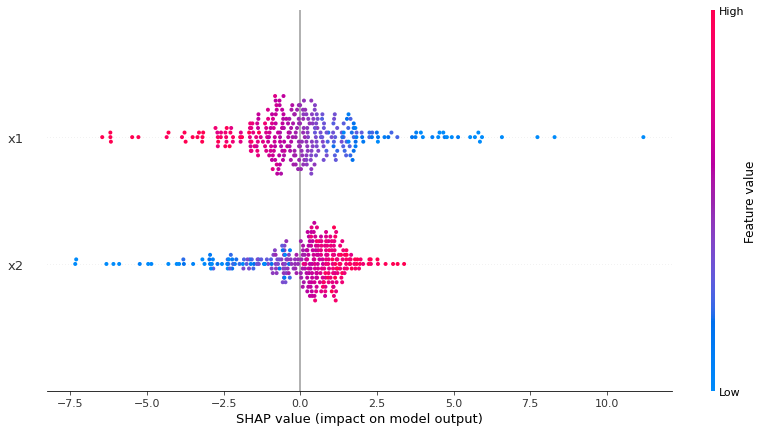

In [15]:
plot_feature_importance_scatter(explanations.indiv_diff.log_odds[:, :, 1])

### Difference Classifier Explanations

The binary difference classifier offers the simplest view. We see, that low feature values of x2 have a huge negative influence on its outcome, which means that for these the individual classifiers most certainly predict equal labels.

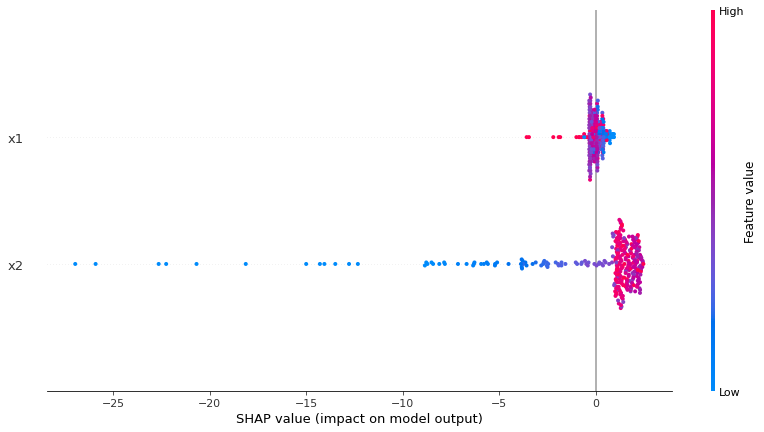

In [33]:
plot_feature_importance_scatter(explanations.bin_diff.log_odds)

The multiclass difference classifier offers the same information, split across several "confusion" classes. In particular, we see that there is a general trend for low values of x1 tend to increase the probability for the confusion class $(1, 0)$ and high values decreasing the same. For x2 we see the same trend like in the previous figure for both difference classes.

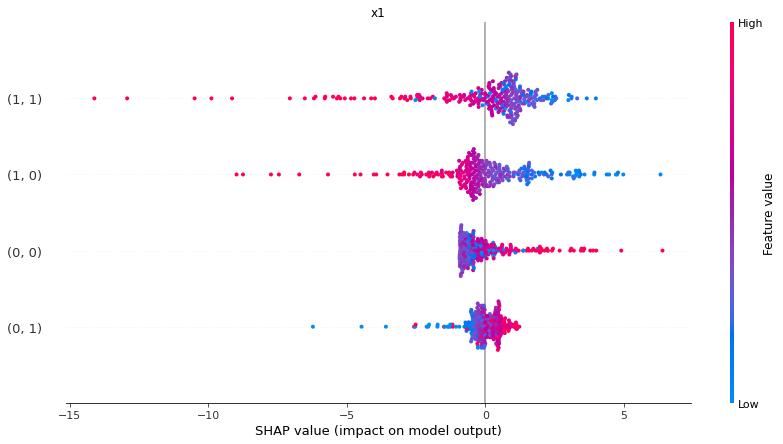

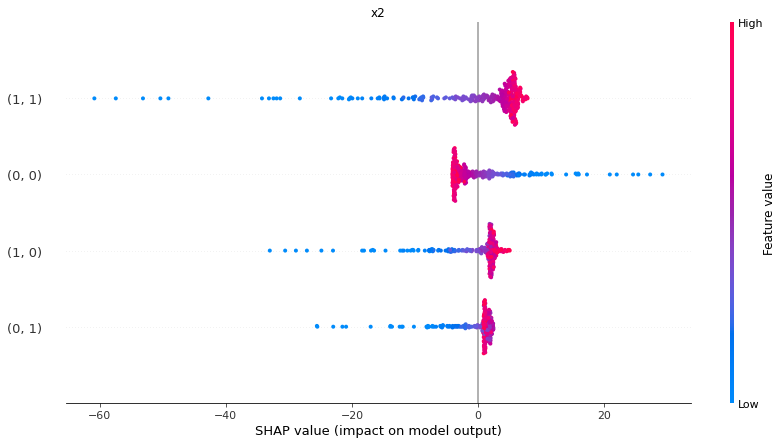

In [32]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds)

Using this, we can obtain a feature order, ranked by mean absolute influence on the instances with different predictions:

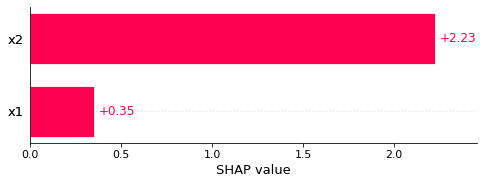

In [5]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
feature_order, feature_importance = calc_feature_order(explanations.bin_diff.log_odds[is_pred_diff])
plot_feature_importance_bar(feature_importance)

## Feature effects

So far, we only investigated the SHAP values distributions. We can visualize the marginal effects a feature has on the outcome jsut like with partial dependence plots, but with more details. Vertical variance suggests, that the effect cannot be explained completely by this feature, but interactions with other features are present.

In [34]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)

We'll colour the instances, that actually have different predictions, red.

### Individual explanations

Generally, B seems to not have any interactions, because it is a clear line. We observe a similar effect of x2 for both models, with some structure visible in the difference (subtraction) of both. For x1, we see bigger differences. Low feature values seem to decrease the probability for the positive outcome in B, whereas this seems not to be the case in A.

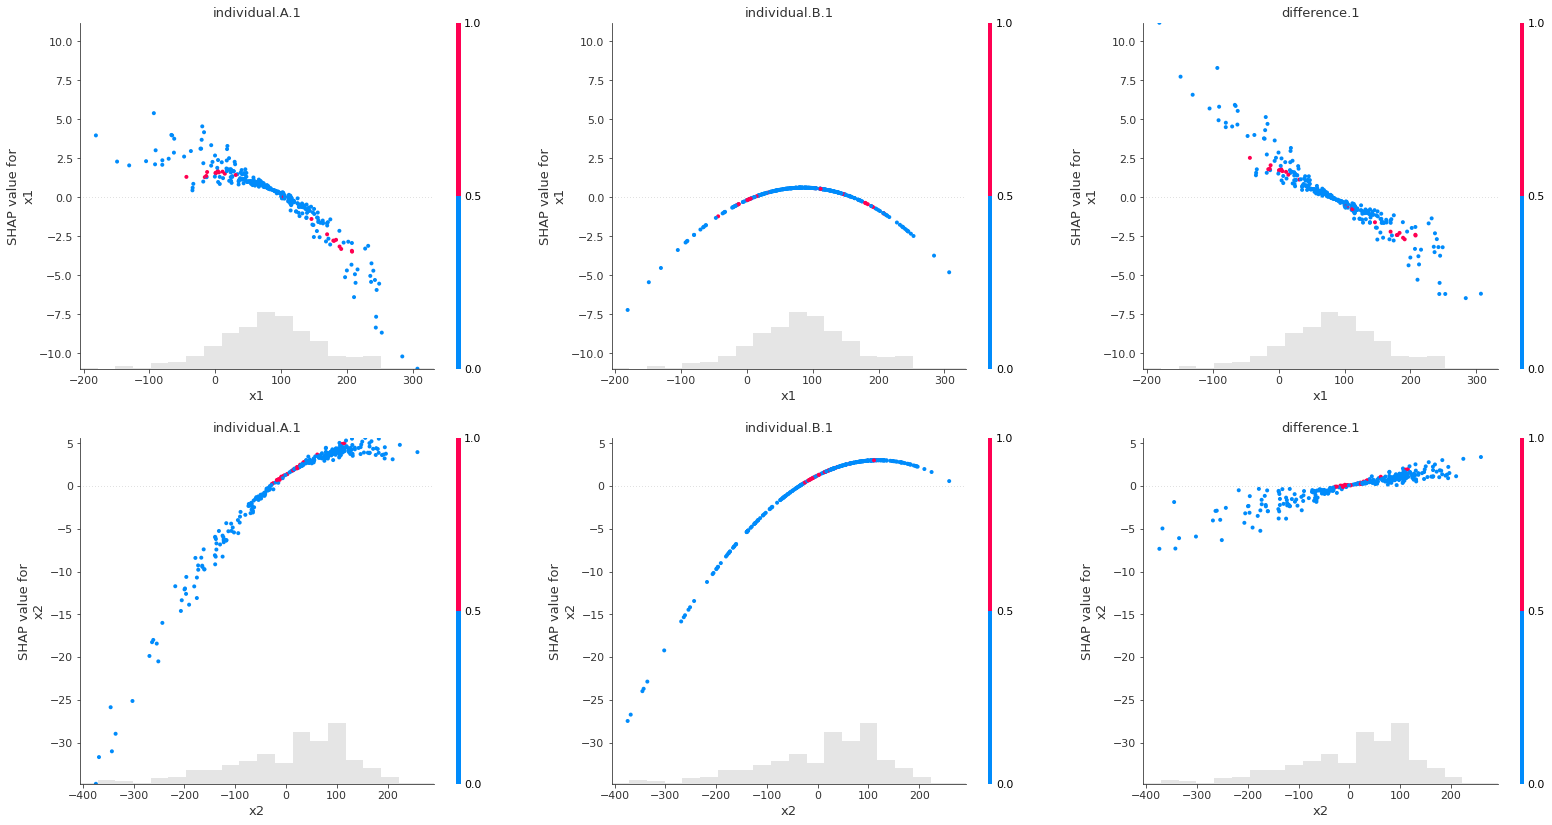

In [35]:
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, :, 1],
                                        difference=explanations.indiv_diff.log_odds[:, :, 1]),
                     color=is_pred_diff)

### Difference classifier explanations

With the feature effects plots for the SHAP values of the binary difference classifier, we can see which feature value ranges have an increased probability for the predictions being different. We see strong interaction effects for x1, and a clear probability increase to a certain level for x2 for increasing values.

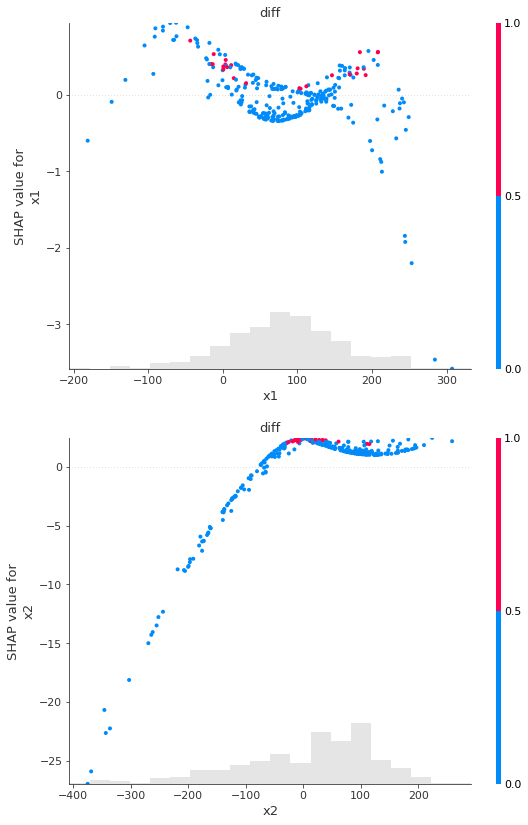

In [26]:
plot_feature_effects(explanations.bin_diff.log_odds, color=is_pred_diff)

With the multiclass difference classifier, the effects for x1 get clearer. We see, that there are basically two clusters, where one has increased difference probability for the confusion of $(0, 1)$, and the other for $(1, 0)$.

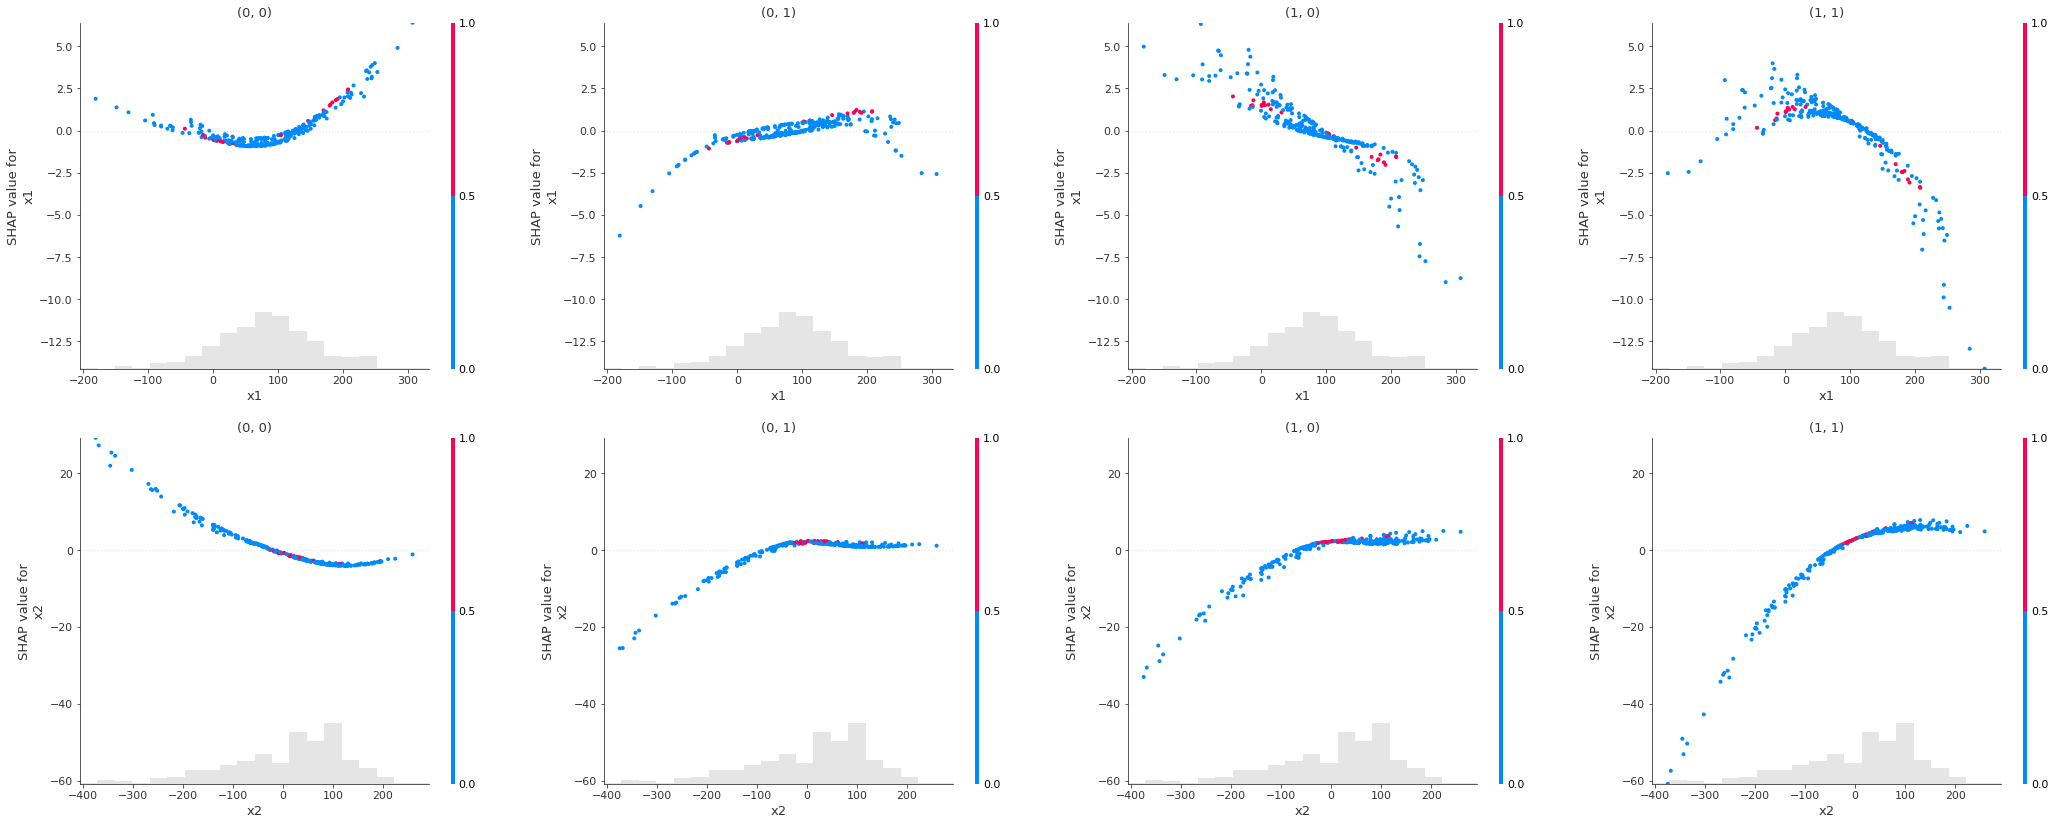

In [25]:
plot_feature_effects(explanations.mclass_diff.log_odds, color=is_pred_diff)